<a id='top'></a>
# Analys av COVID-19 i Sverige

All data kommer från [Folkhälsomyndigheten](https://www.folkhalsomyndigheten.se/smittskydd-beredskap/utbrott/aktuella-utbrott/covid-19/bekraftade-fall-i-sverige/).

Folkhälsomyndigheten visar sin statistik [här](https://experience.arcgis.com/experience/09f821667ce64bf7be6f9f87457ed9aa).

### Innehållsförteckning
1. [Antal fall över tid](#antal_fall_över_tid)
2. [Fördelning av sjukdomsfall](#sjukdomsutfall)
3. [Avlidna vs antal fall](#scatter)
4. [Pandemiutveckling](#trajectory)
5. [SEIRD model](#seir)
6. [Underrapportering - UK](#underrapportering_uk)
7. [Underrapportering - Sverige](#underrapportering_se)

In [25]:
import datetime
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import xlrd
%matplotlib inline

df = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx")
dfi = df.set_index('Statistikdatum')

df_region = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=3, index_col='Region')
df_region['Population'] = df_region['Totalt_antal_fall']/df_region['Fall_per_100000_inv']
df_region['Intensivvårdade_per_100000_inv'] = df_region['Totalt_antal_intensivvårdade']/df_region['Population']
df_region['Avlidna_per_100000_inv'] = df_region['Totalt_antal_avlidna']/df_region['Population']

<a id='antal_fall_över_tid'></a>
## Antal fall över tid

[Tillbaka till början](#top)

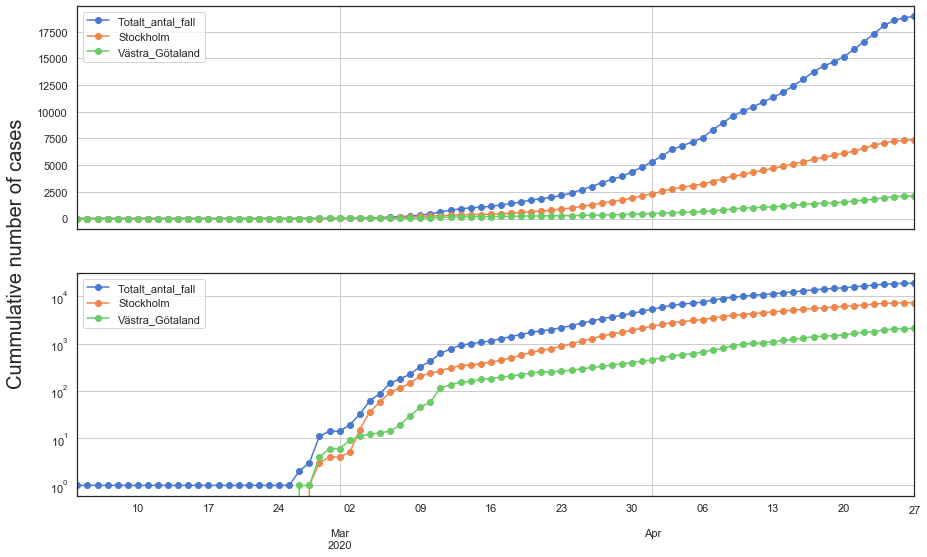

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,9))

y = [
    'Totalt_antal_fall',
    'Stockholm',
    'Västra_Götaland',
#     'Sörmland',
]
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=False, ax=ax1)
dfi.cumsum().plot(y=y, style='-o', grid=True, logy=True, ax=ax2)

ax2.set_xlabel('')
fig.text(0.06, 0.5, 'Cummulative number of cases', va='center', rotation='vertical', fontsize=20);

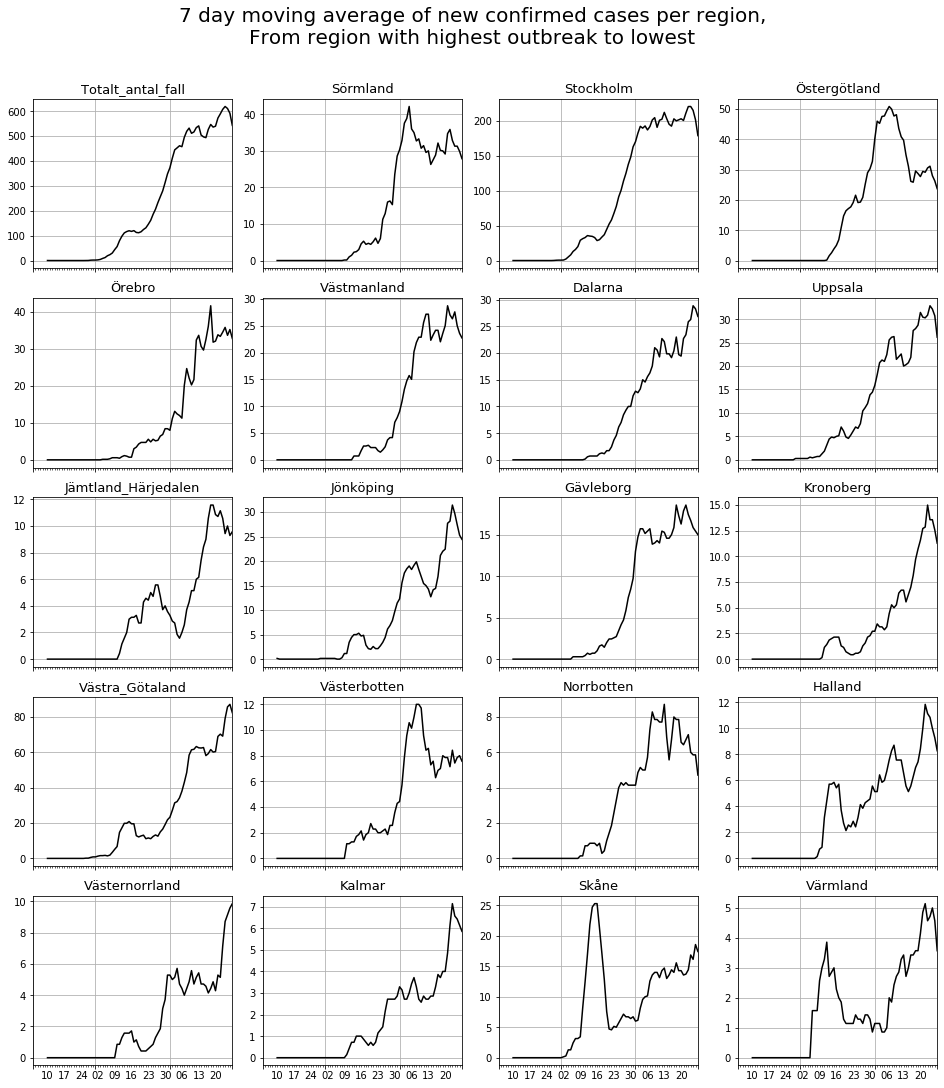

In [3]:
regions = [
    "Totalt_antal_fall",
    "Blekinge",
    "Dalarna",
    "Gotland",
    "Gävleborg",
    "Halland",
    "Jämtland_Härjedalen",
    "Jönköping",
    "Kalmar",
    "Kronoberg",
    "Norrbotten",
    "Skåne",
    "Stockholm",
    "Sörmland",
    "Uppsala",
    "Värmland",
    "Västerbotten",
    "Västernorrland",
    "Västmanland",
    "Västra_Götaland",
    "Örebro",
    "Östergötland"]


sorted_regions = list(df_region.Fall_per_100000_inv.sort_values(ascending=False).index)
sorted_regions = [i.replace(' ', '_') for i in sorted_regions]
sorted_regions.insert(0, 'Totalt_antal_fall')
for region in sorted_regions:
    if region not in regions:
        sorted_regions.remove(region)

    
nrows = 5
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13,15), constrained_layout=True, sharex=True)
axes = np.reshape(axes, -1)

window = 7
fig.suptitle(f'{window} day moving average of new confirmed cases per region,\nFrom region with highest outbreak to lowest\n', fontsize=20)
for region, ax in zip(sorted_regions, axes):
    df_temp = dfi[region].rolling(window).mean()
    df_temp.plot(grid=True, ax=ax, color='k')
    ax.set_title(region, fontsize=13)
    
    ax.set_xlabel('')
    ax.set_xticklabels('')


<a id='sjukdomsutfall'></a>
## Fördelning av sjukdomsutfall

[Tillbaka till början](#top)

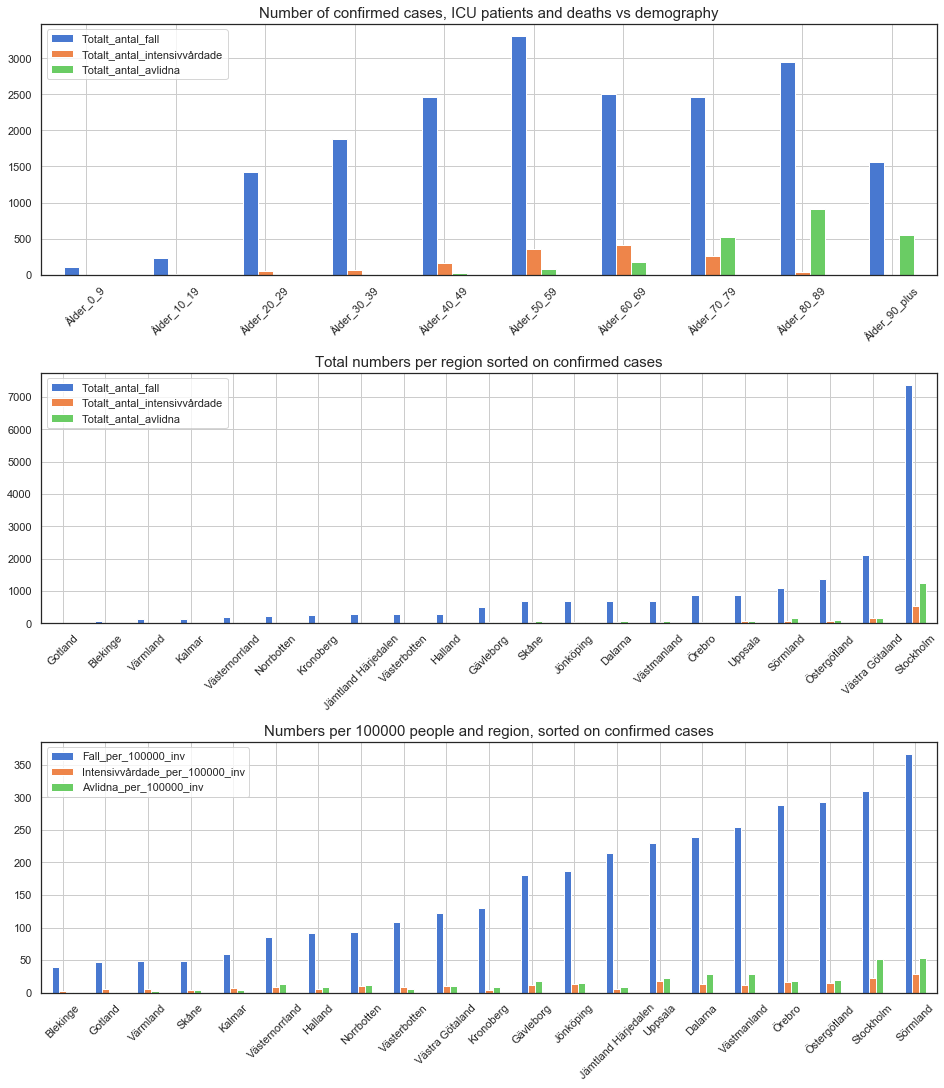

In [14]:
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)

df_age = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=5)
df_age = df_age.iloc[:-1]
df_age.set_index('Åldersgrupp', inplace=True)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(13,15))

df_age.plot(kind='bar', grid=True, ax=ax1, rot=45)
ax1.set_title('Number of confirmed cases, ICU patients and deaths vs demography', fontsize=15)
ax1.set_xlabel('')

df_region.sort_values(by=['Totalt_antal_fall']).plot.bar(y=['Totalt_antal_fall', 'Totalt_antal_intensivvårdade', 'Totalt_antal_avlidna'], grid=True, ax=ax2, rot=45)
ax2.set_xlabel('')
ax2.set_title('Total numbers per region sorted on confirmed cases', fontsize=15)

df_region.sort_values(by=['Fall_per_100000_inv']).plot.bar(y=['Fall_per_100000_inv', 'Intensivvårdade_per_100000_inv', 'Avlidna_per_100000_inv'], grid=True, ax=ax3, rot=45)
ax3.set_xlabel('')
ax3.set_title('Numbers per 100000 people and region, sorted on confirmed cases', fontsize=15);

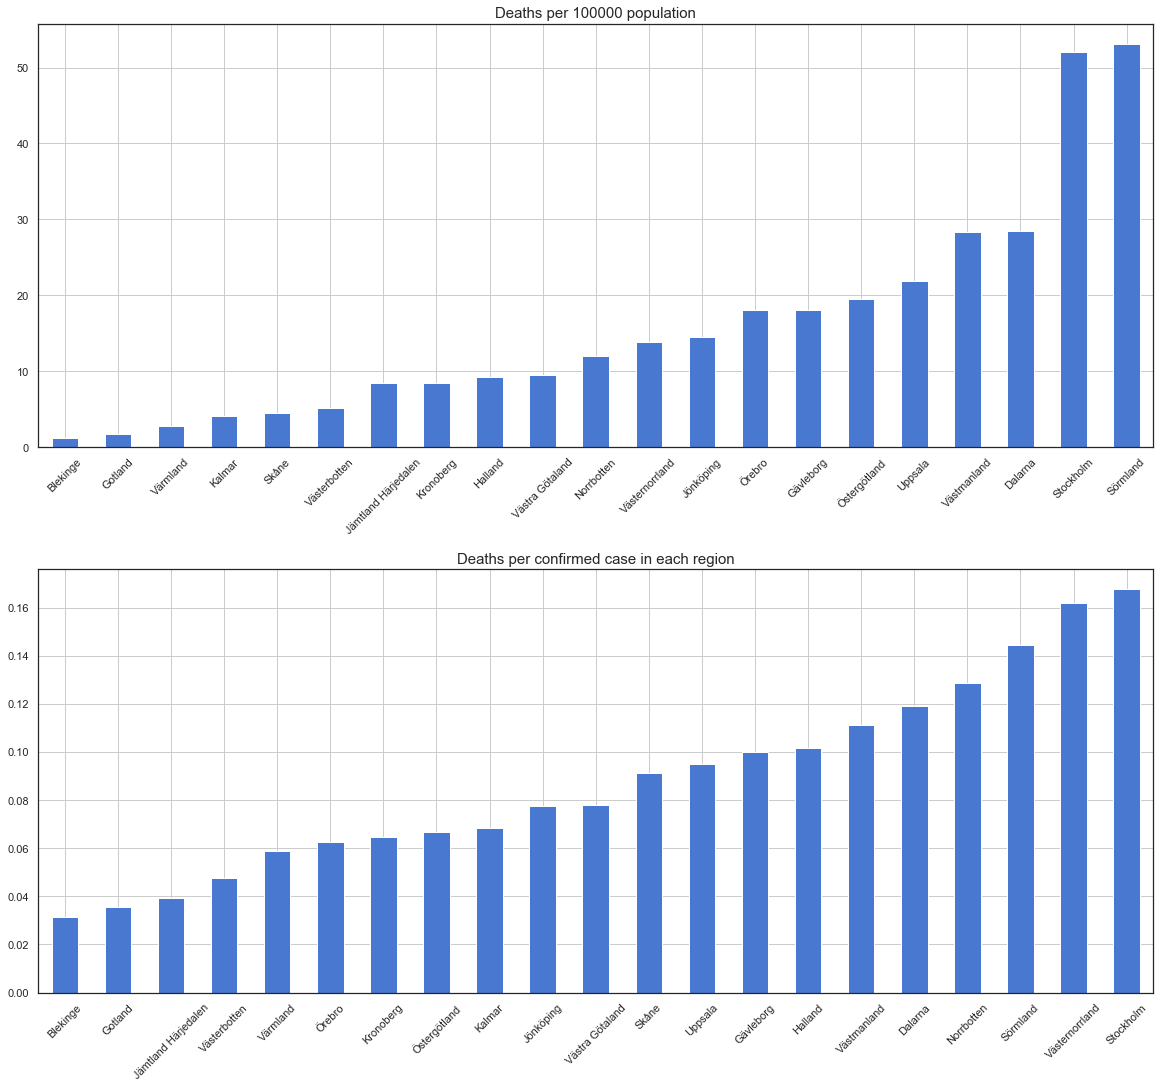

In [16]:
df_avlidna = pd.DataFrame(df_region['Totalt_antal_avlidna']*df_region['Fall_per_100000_inv']/df_region['Totalt_antal_fall'])
df_avlidna.columns = ['Avlidna_per_100000_inv']
df_avlidna['Avlidna_per_fall'] = df_region['Totalt_antal_avlidna'] / df_region['Totalt_antal_fall']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,15), constrained_layout=True)

df_avlidna['Avlidna_per_100000_inv'].sort_values().plot(kind='bar', grid=True, rot=45, ax=ax1)
ax1.set_title('Deaths per 100000 population', fontsize=15)
ax1.set_xlabel('')

df_avlidna['Avlidna_per_fall'].sort_values().plot(kind='bar', grid=True, rot=45, ax=ax2)
ax2.set_title('Deaths per confirmed case in each region', fontsize=15)
ax2.set_xlabel('');

<a id='scatter'></a>
## Avlidna vs antal fall

[Tillbaka till början](#top)

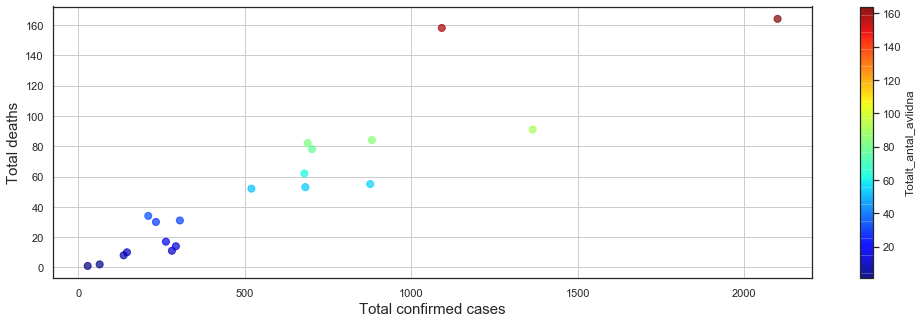

In [17]:
fig, ax = plt.subplots(figsize=(17,5))
plot_kwargs = {
    'grid': True,
    's': 50,
    'alpha': 0.7,
    'c': 'Totalt_antal_avlidna',
    'colormap': 'jet', 
    'ax': ax,}

df_region.drop('Stockholm', axis=0).plot.scatter(x='Totalt_antal_fall', y='Totalt_antal_avlidna', **plot_kwargs)
ax.set_ylabel('Total deaths', fontsize=15)
ax.set_xlabel('Total confirmed cases', fontsize=15);

<a id='trajectory'></a>
## Pandemiutveckling

Denna beräkningen är tagen från youtubekanalen [minutephysics](https://www.youtube.com/watch?v=54XLXg4fYsc)

[Tillbaka till början](#top)

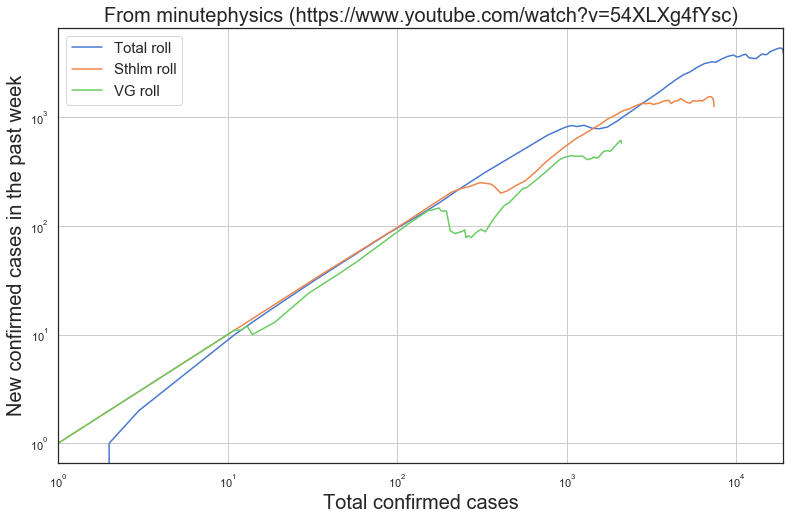

In [18]:
minutephysics = "https://www.youtube.com/watch?v=54XLXg4fYsc"
cols = ['Totalt_antal_fall', 'Stockholm', 'Västra_Götaland']
df_mp = df[cols]
df_mp.loc[:,'sthlm_roll'] = df_mp['Stockholm'].rolling(7).sum()
df_tmp = df_mp[cols].rolling(7).sum()
df_tmp.columns = ['Total roll', 'Sthlm roll', 'VG roll']
df_roll = pd.concat([df_mp.cumsum(), df_tmp], axis=1, sort=False)

fig, ax = plt.subplots(figsize=(13,8))
df_roll.plot(x='Totalt_antal_fall', y='Total roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Stockholm', y='Sthlm roll', grid=True, loglog=True, ax=ax)
df_roll.plot(x='Västra_Götaland', y='VG roll', grid=True, loglog=True, ax=ax)

ax.set_ylabel('New confirmed cases in the past week', fontsize=20)
ax.set_xlabel('Total confirmed cases', fontsize=20)
ax.set_title(f"From minutephysics ({minutephysics})", fontsize=20)
ax.legend(fontsize=15);


<a id='seir'></a>
## SIR model

SEIR-modell beskrivs [här](https://www.idmod.org/docs/hiv/model-seir.html)

[Tillbaka till början](#top)

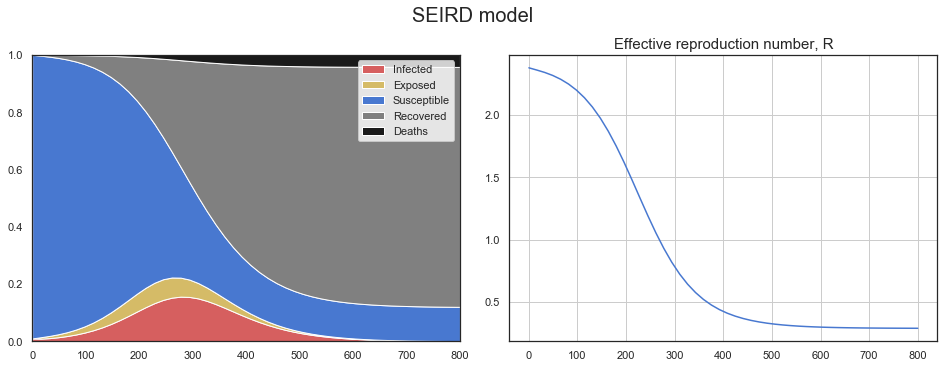

In [19]:

def seir(y, t, N, beta, sigma, gamma, theta=0, rho=0):
    """
    beta:  Infection rate (leaving S)
    sigma: Infectious rate (leaving E)
    gamma: Recovery rate 
    theta: Death rate
    rho:   Loss of immunity rate
    """
    S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
    
    dS = rho*R - beta*I*S/N
    dE = beta*I*S/N - sigma*E
    dI = sigma*E - (gamma + theta)*I
    dR = gamma*I - rho*R
    dD = theta*I
    
    return [dS, dE, dI, dR, dD]

N = 1
S0 = 0.99*N
E0 = 0
I0 = (N-S0)
R0 = 0
D0 = 0

r0 = 2.5
beta  = 0.05
sigma = 0.05
gamma = beta*S0/N/r0
theta = 0.001
rho = 0

y0 = [S0, E0, I0, R0, D0]
t_max = 800
t = np.linspace(0, t_max)

soln = odeint(seir, y0, t, args=(N, beta, sigma, gamma, theta, rho))
S, E, I, R, D = soln[:,0], soln[:,1], soln[:,2], soln[:,3], soln[:,4]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5), constrained_layout=True)
fig.suptitle('SEIRD model', fontsize=20)

ax1.stackplot(t, [I,E,S,R,D], labels=['Infected','Exposed','Susceptible','Recovered','Deaths'], colors=['r', 'y', 'b', 'gray', 'k'])
ax1.legend()
ax1.axis([0, t_max, 0, N])


r = (beta*S*I/N + rho*R) / ((gamma + theta)*I)
ax2.plot(t,r)
ax2.grid()
ax2.set_title('Effective reproduction number, R', fontsize=15);

<a id='underrapportering_uk'></a>
## Underrapportering - UK


[Tillbaka till början](#top)

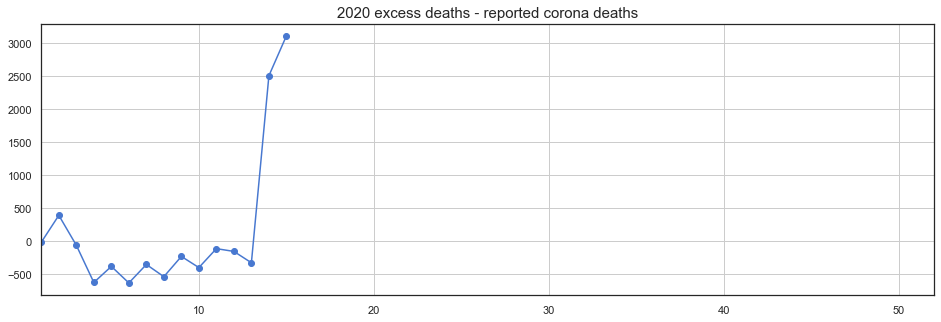

In [20]:
df_uk = pd.read_excel('weekly_deaths_uk_2019.xlsx').transpose()
# df_uk_cumsum = df_uk.cumsum()
df_uk.columns = ['weekly_2019', 'weekly_2020', 'daily_covid19_deaths']

weekly_corona = [0]*9
weekly_corona.extend(df_uk.daily_covid19_deaths.fillna(0).to_numpy()[:-3].reshape(-1,7).sum(axis=1).tolist())
weekly_corona.extend([np.nan]*(52-len(weekly_corona)))
df_uk['weekly_covid19'] = weekly_corona
df_uk.drop('daily_covid19_deaths', axis=1, inplace=True)

df_uk['Total_death_diff'] = df_uk['weekly_2020'] - df_uk['weekly_2019']

df_uk['Excessive_deaths'] = df_uk['Total_death_diff'] - df_uk['weekly_covid19']

fig, ax = plt.subplots(figsize=(16,5))
df_uk.plot(y=['Excessive_deaths'], grid=True, marker='o', ax=ax, legend=False)
ax.set_title('2020 excess deaths - reported corona deaths', fontsize=15);

<a id='underrapportering_se'></a>
## Underrapportering - Sverige

Statistik över totalt antal döda hämtas från [SCB](https://scb.se/hitta-statistik/statistik-efter-amne/befolkning/befolkningens-sammansattning/befolkningsstatistik/) (Preliminär statistik över döda).

Se även [New York Times](https://www.nytimes.com/interactive/2020/04/21/world/coronavirus-missing-deaths.html) artikel.

[Tillbaka till början](#top)

### Antal dödsfall 2020 jämfört med tidigare år

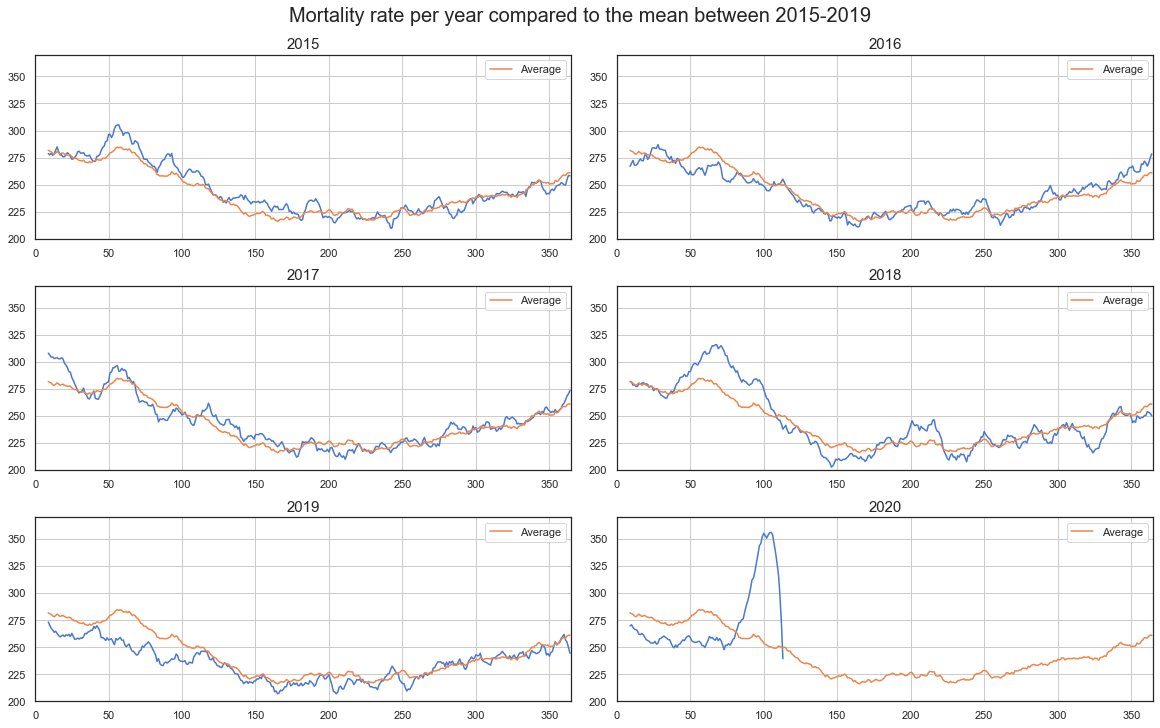

In [31]:
a = []
for i in data.keys():
    if not 'average' in i:
        a.append(df_sweden[i].rolling(10).mean().to_list())
        
fig, ax = plt.subplots(3,2,figsize=(16,10), constrained_layout=True)
fig.suptitle('Mortality rate per year compared to the mean between 2015-2019', fontsize=20)
ax = np.reshape(ax,-1)

year = 2015
ylims = [1000, 0]
for axes, y in zip(ax, a):
    axes.plot(y, label='')
    axes.plot(df_sweden['Deaths_average'].rolling(10).mean().to_list(), label='Average')
    axes.grid(True)
    axes.set_title(f"{year}", fontsize=15)
    axes.legend()
    y_min, y_max = axes.get_ylim()
    axes.axis([0, 365, 200, 370])
    year+=1
    

### Antal dödsfall 2020 jämfört med tidigare år, exklusive covid-dödsfall

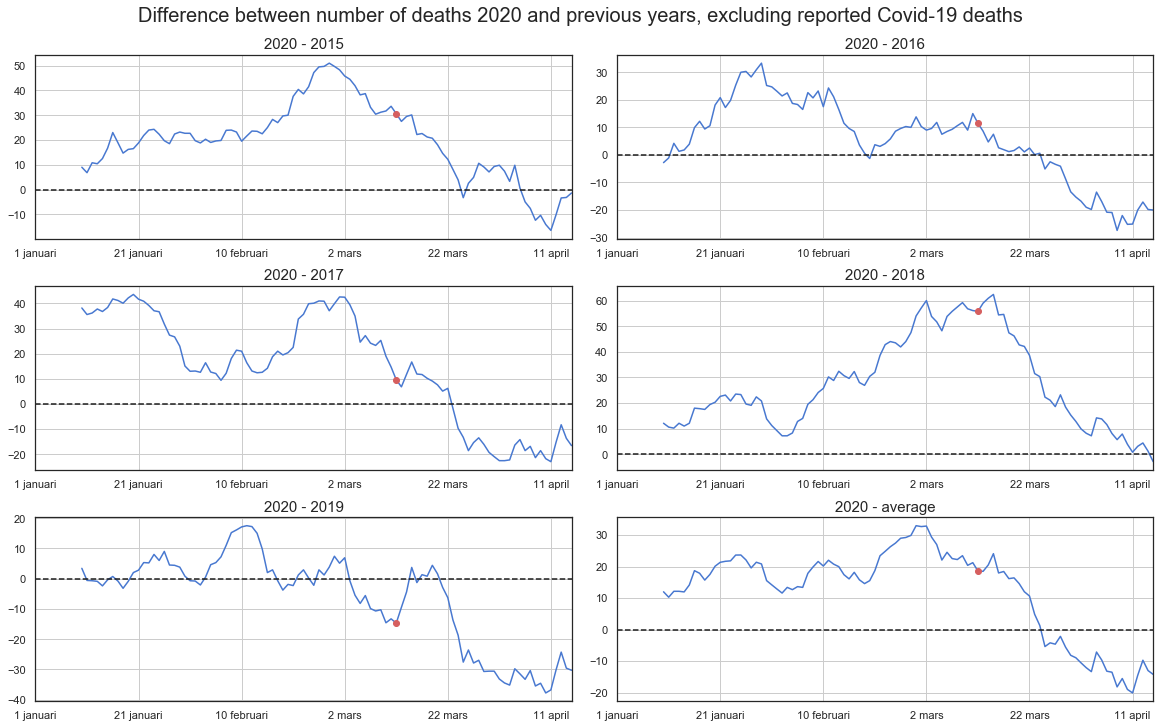

In [46]:
# Find latest statistic file from SCB
scb_file = '2020-04-17---preliminar-statistik-over-doda-inkl-eng.xlsx'
for file in os.listdir('SCB_statistik'):
    if 'preliminar-statistik-over-doda' in file:
        scb_date = datetime.datetime.strptime(scb_file.split('---')[0], '%Y-%m-%d')
        file_date = datetime.datetime.strptime(file.split('---')[0], '%Y-%m-%d')
        if file_date > scb_date:
            scb_file = file

workbook = xlrd.open_workbook(f"SCB_statistik/{scb_file}", on_demand=True)
worksheet = workbook.sheet_by_name('Tabell 1')
df_corona_deaths = pd.read_excel("Folkhalsomyndigheten_Covid19.xlsx", sheet_name=1, usecols="B")

dates = worksheet.col_values(0,7,373)

deaths_2015 = worksheet.col_values(1, 7, 373)
deaths_2016 = worksheet.col_values(2, 7, 373)
deaths_2017 = worksheet.col_values(3, 7, 373)
deaths_2018 = worksheet.col_values(4, 7, 373)
deaths_2019 = worksheet.col_values(5, 7, 373)
deaths_2020 = worksheet.col_values(6, 7, 373)
deaths_avg = worksheet.col_values(7, 7, 373)

data = {
    'Deaths_2015': deaths_2015,
    'Deaths_2016': deaths_2016,
    'Deaths_2017': deaths_2017,
    'Deaths_2018': deaths_2018,
    'Deaths_2019': deaths_2019,
    'Deaths_2020': deaths_2020,
    'Deaths_average': deaths_avg,
}

df_sweden = pd.DataFrame(data, index=dates)
df_sweden.drop(['29 februari'], inplace=True)
df_sweden.loc[df_sweden['Deaths_2020'] == 0, 'Deaths_2020'] = np.nan

list_corona_deaths = df_corona_deaths['Antal_avlidna'].to_list()
df_sweden['Corona_deaths'] = 0
index_first_death = 70
index_last_day = index_first_death+len(list_corona_deaths)
df_sweden.iloc[index_first_death:index_last_day,7] = list_corona_deaths

for year in data.keys():
    year = year.split('_')[-1]
    df_sweden[f'Excess_deaths_{year}'] = df_sweden['Deaths_2020'] - df_sweden[f'Deaths_{year}']
    df_sweden[f'Difference_{year}'] = df_sweden['Corona_deaths'] - df_sweden[f'Excess_deaths_{year}']

fig, ax = plt.subplots(3, 2, figsize=(16,10), constrained_layout=True)
fig.suptitle('Difference between number of deaths 2020 and previous years, excluding reported Covid-19 deaths', fontsize=20)
ax = np.reshape(ax,-1)
last_reliable_day = min(index_last_day, deaths_2020.index(0))-10

year = ['2015', '2016', '2017', '2018', '2019', 'average']
for y, axes in zip(year, ax):
    df_sweden.rolling(10).mean().iloc[:last_reliable_day,:].plot(y=[f'Difference_{y}'], grid=True, legend=False, ax=axes)
    axes.plot(index_first_death, df_sweden.rolling(10).mean().iloc[index_first_death,:][f'Difference_{y}'], 'ro')
    axes.set_title(f'2020 - {y}', fontsize=15)
    axes.axhline(color='k', ls='--')

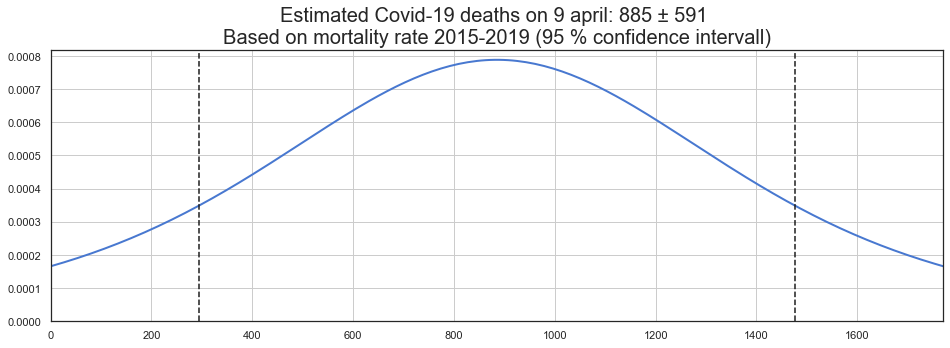

In [45]:
# Mean deaths for all years
years = np.arange(2015,2020)
X = df_sweden[[f'Excess_deaths_{year}' for year in years]].iloc[index_first_death:last_reliable_day,:].sum()
X_mean = X.mean()

# Sample variance for all years
n = len(years)
X_var = sum((X_mean-X)**2)/(n-1)
S = np.sqrt(X_var)

# two sided t-value from the t-distribution
deg = n-1
t_value = stats.t.ppf(0.975, df=deg)

# Confidence intervall
ci = t_value*S/np.sqrt(n)

# print(f"Number of Covid-19 deaths is estimated to be {X_mean} \u00B1 {round(ci):0.0f} based on mortality rate 2015-2019 (95 % confidence intervall)")

fig, ax = plt.subplots(figsize=(16,5))
x = np.linspace(0, 2*X_mean, 200)
ax.plot(x, stats.t.pdf(x, deg, loc=X_mean, scale=S), lw=2)
ax.grid()
stat_day = df_sweden.index[last_reliable_day]
ax.set_title(f"Estimated Covid-19 deaths on {stat_day}: {round(X_mean):0.0f} \u00B1 {round(ci):0.0f} \nBased on mortality rate 2015-2019 (95 % confidence intervall)", fontsize=20);
ax.set_xlim([0, 2*X_mean])
ylim = ax.get_ylim()
ax.set_ylim([0, ylim[1]])

ax.plot([X_mean-ci]*2, [0, ylim[1]], '--k')
ax.plot([X_mean+ci]*2, [0, ylim[1]], '--k');


In [43]:
df_temp = pd.read_excel('Folkhalsomyndigheten_Covid19.xlsx', sheet_name=1)
df_temp.set_index('Datum_avliden', inplace=True)
df_temp.cumsum()

,Antal_avlidna
Datum_avliden,
2020-03-11 00:00:00,1
2020-03-12 00:00:00,1
2020-03-13 00:00:00,2
2020-03-14 00:00:00,3
2020-03-15 00:00:00,5
2020-03-16 00:00:00,7
2020-03-17 00:00:00,8
2020-03-18 00:00:00,14
2020-03-19 00:00:00,21
